In [1]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [3]:
Bag = load_npy("Bag")
Hips = load_npy("Hips")
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(28685, 28)

In [13]:
Bag_train, Bag_val = train_test_split(Bag, test_size=0.3)
Hips_train, Hips_val = train_test_split(Hips, test_size=0.3)
Torso_train, Torso_val = train_test_split(Torso, test_size=0.3)
Hand_train, Hand_val = train_test_split(Hand, test_size=0.3)

Hand_train.shape, Hand_test.shape

((20079, 28), (8606, 28))

In [7]:
def load_npy():
    file_path = "../Output/test/test"
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [8]:
test = load_npy()
test.shape

(57573, 28)

In [10]:
Y_train = [0] * 20079 + [1] * 20079 + [2] * 20079 + [3] * 20079
Y_train = np.array(Y_train).reshape([-1, 1])

Y_val = [0] * 8606 + [1] * 8606 + [2] * 8606 + [3] * 8606
Y_val = np.array(Y_val).reshape([-1, 1])

Y_train.shape, Y_val.shape

((80316, 1), (34424, 1))

In [14]:
X_train = np.concatenate([Bag_train, Hips_train, Torso_train, Hand_train])
X_val = np.concatenate([Bag_val, Hips_val, Torso_val, Hand_val])

X_train.shape, X_val.shape

((80316, 28), (34424, 28))

In [15]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0,
                         gamma=0.1, sub_sample=1.0, colsample_bytree=1.0)
model.fit(X_train, Y_train)

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=1.0, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [16]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

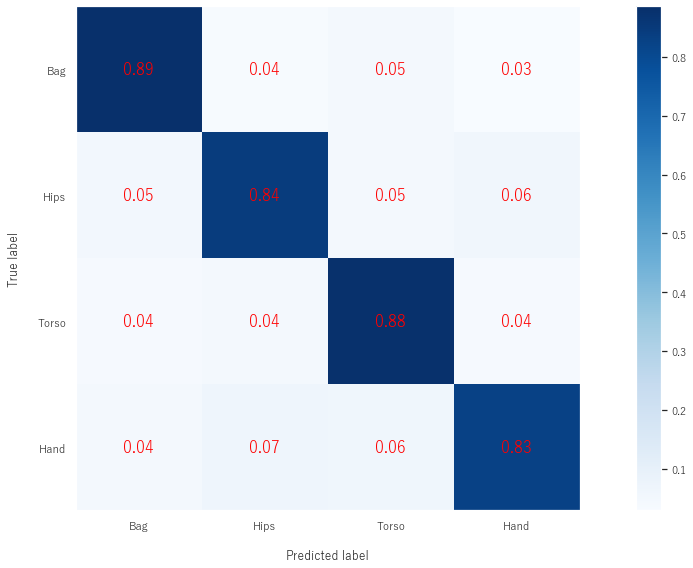

In [17]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X_val)
plot_confusion_matrix(Y_val, predict, class_names, True)
plt.grid(False)

In [21]:
predict = model.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i+1)))

Bag：8230
Hips：5416
Torso：17751
Hand：0


# Validationデータをすべて学習させる

In [23]:
X = np.concatenate([Bag, Hips, Torso, Hand])
Y = [0] * 28685 + [1] * 28685 + [2] * 28685 + [3] * 28685
Y = np.array(Y).reshape([-1, 1])
X.shape, Y.shape

((114740, 28), (114740, 1))

In [24]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0,
                         gamma=0.1, sub_sample=1.0, colsample_bytree=1.0)
model.fit(X, Y)

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=1.0, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [25]:
predict = model.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i+1)))

Bag：8486
Hips：5187
Torso：17576
Hand：0


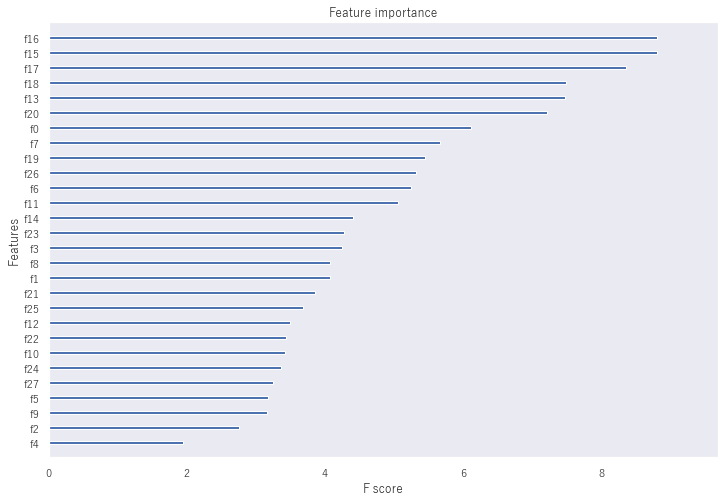

In [28]:
_, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.grid(False)